In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

from imp import reload

import qcodes as qc

qc.set_mp_method('spawn')  # force Windows behavior on mac

# this makes a widget in the corner of the window to show and control
# subprocesses and any output they would print to the terminal
qc.show_subprocess_widget()

C:\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>

In [27]:
import qcodes.instrument_drivers.rohde_schwarz.ZNB20 as vna; reload(vna)

<module 'qcodes.instrument_drivers.rohde_schwarz.ZNB20' from 'a:\\qcodesfolder\\qcodes\\instrument_drivers\\rohde_schwarz\\ZNB20.py'>

In [28]:
v1 =vna.ZNB20('VNA', 'TCPIP0::172.20.2.234::inst0::INSTR', server_name=None)

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101551, firmware:2.10) in 0.04s


### Basic Use
Default settings, VNA measures S21 and can perform frequency sweeps with given parameters

In [ ]:
# basic settings available (feel free to add more to the driver!)
v1.bandwidth(500)
v1.power(-50)
# functions: (all also have 'off')
v1.tooltip_on() #shows errors on intrument screen
v1.cont_meas_on() #instrument continiously sweeps frequency
v1.update_display_on() #shows measurement on instrument screen (slows it down a bit)
v1.rf_on() #turns on all ports 
v1.update_display_once()

In [ ]:
# setting up frequency trace params (set here as sweep is hardware controlled)
v1.start(100e6)
v1.stop(800e6)
v1.avg(2)
v1.npts(71)

In [54]:
# getting a single trace
v1.trace()

([0.9895826882081791,
  0.9869094348257063,
  0.9857022207845295,
  0.9849716811324213,
  0.9851777067679051,
  0.9842607626269199,
  0.9829348381629962,
  0.9816473088019041,
  0.9786861283846768,
  0.977592036189242,
  0.97576729729163,
  0.9740934018474197,
  0.9729518103133459,
  0.9721370921861145,
  0.9713039723260913,
  0.9709207543511132,
  0.9708230438550919,
  0.9703666979337292,
  0.9703414381126192,
  0.9700908859391326,
  0.9699112711672869,
  0.9694166657814337,
  0.968903093853172,
  0.9682554312580419,
  0.9678450187387361,
  0.9671028614781024,
  0.9664735489036151,
  0.965510156267443,
  0.9649242678857383,
  0.9649892999018361,
  0.9644816933427587,
  0.9641921319025079,
  0.963669775695679,
  0.9631865143768873,
  0.963223910382565,
  0.963030553862949,
  0.9624009542078145,
  0.9622513785770892,
  0.9620348386109799,
  0.961453672750619,
  0.9604823245357286,
  0.9601940834710165,
  0.9594606244612337,
  0.9593216823689693,
  0.9589108029090968,
  0.957887367368323

In [52]:
# qcodes loop
data1 = qc.Loop(v1.power.sweep(-15,-2, 1)).each(v1.trace).run(background = False)

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-07-07/14-59-21'
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Setpoint | VNA_power_set | power        | (14,)
   Measured | frequency     | frequency    | (14, 201)
   Measured | VNA_magnitude | magnitude    | (14, 201)
   Measured | VNA_phase     | phase        | (14, 201)
started at 2016-07-07 14:59:22


<IPython.core.display.Javascript object>


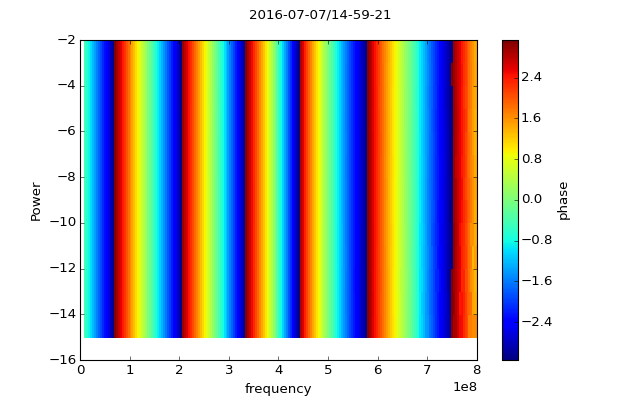

In [55]:
# plot results
qc.MatPlot(data1.VNA_phase)
qc.MatPlot(data1.VNA_magnitude)

### Spectroscopy Mode
This mode is useful for monitoring the response of a resonance whilst sweeping the frequency drive in a different range.

In this mode the VNA is assumed to have at least 3 ports (so actually for ZNB8...)
- Drives port 1 at a fixed frequency
- Drives port 3 which is swept by instrument in trace. 
- Measures the response at port 2 (as before)

In [ ]:
# setting spec mode to 1
v1.spec_mode(1)

# by default the port 1 is now driven at the center frequency of the original sweep and at the same power
v1.fixed_freq(6.61262e9)
v1.fixed_pow(-55)

# set up sweep on port 3
v1.start(7.5e9)
v1.stop(8.5e9)
v1.avg(2)
v1.npts(501)
v1.power(-30)

In [ ]:
# qcodes loop - demo of what you might want to do (can also be used exactly the same as above)
# TODO(nataliejpg): check this works and either use loop index more cleverly or actual power values
i = 0
data2 = qc.Loop(v1.power.sweep(-15,-2, 1)).each(
    max_cav_index = data1.VNA_magnitude[i].argmax()
    max_cav_freq = data1.frequency[max_cav_index]
    qc.Task(v1.fixed_freq.set, max_cav_freq) 
    i+= 1
    v1.trace).run()

In [ ]:
# plot results
qc.MatPlot(data2.VNA_phase)
qc.MatPlot(data2.VNA_magnitude)